In [2]:
from Plot_Functions import CollectData

import numpy as np
import pandas as pd
import json



from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

import scipy
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import NonlinearConstraint


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.model_selection import train_test_split


import seaborn as sns
import GPy
import GPyOpt
from numpy.random import seed


from matplotlib.font_manager import FontProperties
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 20,
    'style'  : 'normal'}

# font = {'family' : 'Helevatica',
#     'weight' : 'medium',
#     'size'   : 20,
#     'style'  : 'normal'}
import pickle

## Different Cut Offs

In [3]:
RMSEP_cutoff = pd.read_excel("Error_CutOff.xlsx","RMSEP").iloc[:,1:]
RMSEP_wt_cutoff = pd.read_excel("Error_CutOff.xlsx","RMSEP_wt").iloc[:,1:]


[0.5 1.5 2.5 3.5 4.5]


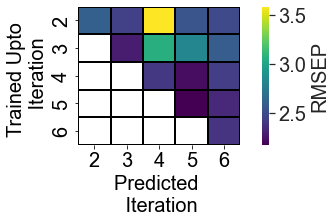

In [4]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (4,4)
fig, axs = plt.subplots(1, 1) 
plt.gcf().subplots_adjust(bottom=0.4, left = 0.15)
sns.set(font = "Arial")

h_map = sns.heatmap(RMSEP_cutoff, linewidths=2,  linecolor = 'black',
            cmap= sns.color_palette("viridis", as_cmap=True),
            cbar_kws={'label': 'RMSEP', 'pad':0.1})

axs.set_yticklabels([2,3,4,5,6], **hfont)
axs.set_xticklabels( [2,3,4,5,6], **hfont)

axs.set_xlabel("Predicted \n Iteration", **hfont)
axs.set_ylabel("Trained Upto \n Iteration", **hfont)

print(h_map.get_yticks())
cbar = h_map.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='RMSEP', fontsize = 20, font = 'Arial')
plt.savefig("./Plots/DifferentCutoff_HM.pdf", dpi = 600, bbox_inches = "tight")

In [11]:
cut_off_round = 6
Molecule_list = ['RBDJ','HSA', 'Trastuzumab'] 
fname = ['RBDJ_ErrorChart.pkl','HSA_ErrorChart.pkl', 'HerA_ErrorChart.pkl' ]
fname2 = ['RBDJ_Kernel.pkl','HSA_Kernel.pkl', 'HerA_Kernel.pkl' ]
N_round_list = [6,6, 6]
root_path = './'
carbon_source_filepath = './'

In [30]:
cnt = 0
ErrorChart = {}
rmsep= {}
Kernel = {}

for m in Molecule_list: 
    main_file_path = root_path + m + "/Codes/" + fname[cnt]
    with open(main_file_path, "rb") as fp:
        ErrorChart[m] = pickle.load(fp)
        
    
    main_file_path2 = root_path + m +"/Codes/"+ fname2[cnt]
    with open(main_file_path2, "rb") as fp:
        temp = pickle.load(fp)
        Kernel[m] = list(temp.values())
        
    rmsep[m] =  np.zeros((2,6))
    for i in range(1,7):
        rmsep[m][0, i-1] =  ErrorChart[m]['RMSEP'][i]
        rmsep[m][1, i-1] =  ErrorChart[m]['RMSEP_wt'][i-1]
    
    
    cnt =cnt+1

RBDJ
RBDJ_ErrorChart.pkl
HSA
HSA_ErrorChart.pkl
Trastuzumab
HerA_ErrorChart.pkl


## Kernel Selection

In [15]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

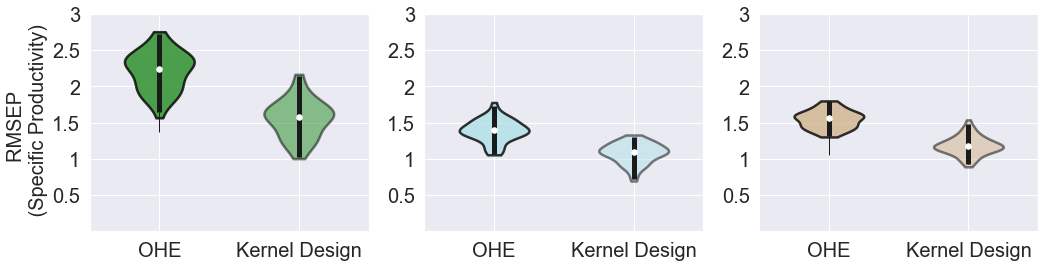

In [33]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (17, 4)
f, ax = plt.subplots(1, 3)

c_name = [ 'forestgreen','powderblue', 'tan'] #'thistle',  ,'forestgreen'

for m in range(3):
    plt_data2 = Kernel[Molecule_list[m]][0]
    plt_data = np.concatenate((plt_data2[:,1:2], plt_data2[:,0:1]), axis = 1)
    parts = ax[m].violinplot(plt_data, showmeans=False, showmedians=False,
            showextrema=False)

    cnt = 0
    alpha_list = [0.8, 0.5]
    for pc in parts['bodies']:
        print(pc)
        pc.set_facecolor(c_name[m])
        pc.set_edgecolor('black')
        pc.set_linewidth(2.5)
        pc.set_alpha(alpha_list[cnt])
        cnt = cnt+1


    quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[m].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[m].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[m].vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


    labels = [ 'OHE', 'Kernel Design']
    ax[m].set_xlim([0.5,2.5])
    ax[m].set_xticks([1, 2])
    ax[m].set_xticklabels(labels, **hfont)
    ax[m].set_yticks([0, 0.5,1, 1.5, 2, 2.5, 3])
    ax[m].set_yticklabels(['', 0.5,1, 1.5, 2, 2.5, 3], **hfont)
    ax[0].set_ylabel("RMSEP \n (Specific Productivity)", **hfont)
    
plt.savefig("./Plots/KernelSelection.pdf", dpi = 600, bbox_inches = "tight")

## Convergence

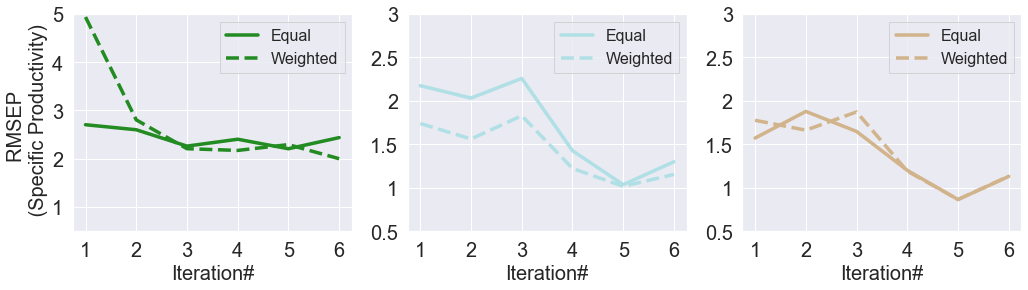

In [34]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (17, 4)
f, ax = plt.subplots(1, 3)

c_name = [ 'forestgreen','powderblue', 'tan'] #'thistle',  ,'forestgreen'


x = np.arange(1, 7)

for m in range(3):
    ax[m].plot(np.arange(1,cut_off_round+1), rmsep[Molecule_list[m]][0, 0:cut_off_round], c = c_name[m], linewidth = 3.5)
    ax[m].plot(np.arange(1,cut_off_round+1), rmsep[Molecule_list[m]][1, 0:cut_off_round], '--', c = c_name[m], linewidth = 3.5)
    ax[m].set_xticks([1,2,3,4,5,6])
    ax[m].set_xticklabels([1,2,3,4,5,6],**hfont)
    if m == 0:
        ax[m].set_yticks([1,2,3,4,5])
        ax[m].set_yticklabels([1,2,3,4,5],**hfont)
    else:
        ax[m].set_yticks([0.5, 1, 1.5, 2, 2.5, 3])
        ax[m].set_yticklabels([0.5, 1, 1.5, 2, 2.5, 3],**hfont)
        
    ax[m].set_xlabel('Iteration#', **hfont)

        
    ax[m].set(ylim = [0.5, 3])
    ax[0].set(ylim = [0.5, 5])
    L = ax[m].legend(['Equal', 'Weighted'], loc = 'upper center',
                      bbox_to_anchor=(0.75,1), fontsize = 16, 
          ncol=1, fancybox=False, shadow=False)
    plt.setp(L.texts, family='Arial')
    
    ax[0].set_ylabel('RMSEP \n (Specific Productivity)', **hfont)
    
plt.savefig("./Plots/MetricTracking.pdf", dpi = 600, bbox_inches = "tight")